<a href="https://colab.research.google.com/github/giangkarry/Woodblock_image_super_resolution/blob/main/SRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
batch_size = 32
num_epochs = 250
learning_rate1 = 1e-4
learning_rate2 = 1e-5
# upscale_factor = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_workers = 2
channel = 3

# Data

In [ ]:
import os
from pathlib import Path
from torch.utils.data.dataset import Dataset
from torchvision.transforms import Compose, ToTensor, Normalize
from PIL import Image
import numpy as np

class HNDataset(Dataset):
  def __init__(self, data_root):
    super(HNDataset, self).__init__()
    self.data_root = data_root
    self.low_dir = os.path.join(self.data_root, "low")
    self.high_dir = os.path.join(self.data_root, "high")
    self.low_image_list = list(Path(self.low_dir). glob("*.png"))
    self.high_image_list = list(Path(self.high_dir). glob("*.png"))
    self.lr_transform = Compose([
            ToTensor(),
        ])
    self.hr_transform = Compose([
            ToTensor(), 
        ])

  def __len__(self):
    return len(self.low_image_list)

  def __getitem__(self, idx):
    low_img = Image.open(self.low_image_list[idx])
    high_img = Image.open(self.high_image_list[idx])
    tensor_low = self.lr_transform(low_img)
    tensor_high = self.hr_transform(high_img)
    return tensor_low, tensor_high

In [ ]:
from torch.utils.data import DataLoader
path = '/content/drive/MyDrive/Data/6TResize/BicubicDataset/'

train_set = HNDataset(path + 'train')
val_set = HNDataset(path + 'validation')
test_set = HNDataset(path + 'test')

train_loader = DataLoader(dataset=train_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, num_workers=num_workers, batch_size=batch_size, shuffle=False)

In [ ]:
print(len(train_loader.dataset),len(test_loader.dataset), len(val_loader.dataset))

4800 600 600


# Xây dựng mô hình SRCNN

In [ ]:
import torch.nn as nn
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.normal_(m.weight, mean=0.0, std=0.001)
        nn.init.zeros_(m.bias)

class SRCNN(nn.Module):
  
  def __init__(self):
    super(SRCNN, self).__init__()
    
    #Patch extraction and representation
    self.block1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=9, padding=4),
        nn.ReLU()
    )

    # Non_linear feature mapping
    self.block2 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=32,kernel_size=5, padding=2),
        nn.ReLU()
    )

    # Reconstruction
    self.block3 = nn.Conv2d(in_channels=32, out_channels=3, kernel_size=5, padding=2)
    self.apply(weights_init)

  def forward(self, x):
    block1 = self.block1(x)
    block2 = self.block2(block1)
    block3 = self.block3(block2)
    return (torch.tanh(block3) + 1) / 2 # thay

# Quality metrics

In [ ]:
import torch
import torch.nn.functional as F
from math import exp
class SSIM:
  def __init__(self, window_size=11, sigma=1.5, size_average=True):
    self.window_size = window_size
    self.size_average = size_average
    self.sigma = sigma

  def gaussian(self):
    gauss = torch.Tensor([exp(-(x-self.window_size//2)**2/float(2*self.sigma**2))for x in range(self.window_size)]) 
    return gauss/gauss.sum() # (window_size)
  
  def create_window(self, channels, groups):
    _1d_window = self.gaussian().unsqueeze(1) #(window_size, 1)
    _2d_window = torch.mm(_1d_window, _1d_window.t()).unsqueeze(0).unsqueeze(0) # (1,1,window_size, window_size)
    window = _2d_window.expand(channels, channels//groups, self.window_size, self.window_size).contiguous()
    return window # (channel, channel/group, window_size, window_size): (3, 1, 11,11)

  def ssim(self, img1, img2):
    channel = img1.shape[1] # <=>img1.size()[1] hoặc (_, channel,_,_) = img1.size(): int
    window = self.create_window(channel, channel) # (3,1,11,11)
    if img1.is_cuda:
      window = window.cuda(img1.get_device())
    mu1 = F.conv2d(img1, window, padding=(self.window_size-1)//2, groups=channel) # (N,c,h,w)
    mu2 = F.conv2d(img2, window, padding=(self.window_size-1)//2, groups=channel) #(N,c,h,w)

    mu1_sq = mu1**2 #(N,c,h,w)
    mu2_sq = mu2**2 #(N,c,h,w)
    mu1_mu2 = mu1*mu2 #(N,c,h,w)
    sigma1_sq = F.conv2d(img1**2, window, padding=(self.window_size-1)//2, groups=channel)-mu1_sq #(N,c,h,w)
    sigma2_sq = F.conv2d(img2**2, window, padding=(self.window_size-1)//2, groups=channel)-mu2_sq #(N,c,h,w)
    sigma12 = F.conv2d(img1*img2, window, padding=(self.window_size-1)//2, groups=channel)-mu1_mu2 #(N,c,h,w)
    C1 = 0.01**2
    C2 = 0.03**2
    
    ssim = ((2.0*mu1_mu2 + C1)*(2.0*sigma12 + C2))/((mu1_sq +mu2_sq+C1)*(sigma1_sq+sigma2_sq+C2)) #(N, c, h, w)
    if self.size_average:
      return ssim.mean() 
    else:
      return ssim.mean(dim=(1,2,3))# tương tự ssim.mean(1).mean(1).mean(1) # batch_size

class PSNR:
  def __init__(self):
    pass
  def update(self, sr, hr):
    data_range = hr.max()
    dim = tuple(range(1,hr.ndim)) #(1,2,3)
    mse_error = torch.pow((sr-hr),2).mean(dim=dim) # (batch_size)
    batch_psnr = 10.0 * torch.log10(1**2/(mse_error)) #(batch_size)
    return batch_psnr

# Huấn luyện

In [ ]:
# from torch.types import Device
from torch.nn import functional as F
import os 
from math import log10
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
# from torchvision.transforms import toTenSor
from torchvision import utils
from torch.autograd import Variable
from tqdm import tqdm # tạo ra thanh tiến trình và các thông báo tiến trình cho các vòng lặp

class SRCNNTrain:
  def __init__(self, netCNN, train_loader, val_loader, cnn_criterion, batch_size, learning_rate1, learning_rate2, num_epochs, ssim, psnr, device='cpu'):
    self.netCNN = netCNN
    self.train_loader = train_loader
    self.val_loader = val_loader
    self.cnn_criterion = cnn_criterion
    self.batch_size = batch_size
    self.learning_rate1 = learning_rate1
    self.num_epochs = num_epochs
    self.device = device
    self.ssim = ssim
    self.psnr = psnr
    self.results = {'ssim':[], 'psnr':[]}

    self.optimizer = optim.Adam([{'params':self.netCNN.block1.parameters()},
                                {'params':self.netCNN.block2.parameters()},
                                {'params':self.netCNN.block3.parameters(), 'lr':learning_rate1}], lr=learning_rate2)

  def results_val(self):
    return self.results; 
  def _train(self, lr_img, hr_img, running_results):
    lr_img = lr_img.to(self.device)
    hr_img = hr_img.to(self.device)

    #Tạo ảnh SR
    fake_img = self.netCNN(lr_img)
    # Tính loss
    loss = self.cnn_criterion(fake_img, hr_img)

    #Optimizer
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    running_results['loss'] += loss.item() * self.batch_size

  def _val(self, lr, hr, val_results):
    lr = lr.to(self.device)
    hr = hr.to(self.device)
    sr = self.netCNN(lr)
    
    #Tính các chỉ số mse, ssim, psnr
    
    batch_ssim = self.ssim.ssim(sr, hr) # (batch_size)
    batch_psnr = self.psnr.update(sr,hr) # (batch_size)
    val_results['ssim'] += torch.sum(batch_ssim)
    val_results['psnr'] += torch.sum(batch_psnr)


  def train(self):
    for epoch in range(self.num_epochs):
      # Khởi tạo progress bar
      train_bar = tqdm(self.train_loader)
      running_results = {'samples': 0, 'loss': 0}
      
      self.netCNN.train()
      
      for lr_img, hr_img in train_bar:
        running_results['samples'] += self.batch_size
        
        self._train(lr_img, hr_img, running_results)

        train_bar.set_description (
          desc='Epoch: [%d/%d] Loss: %.4f' % (
              epoch+1, self.num_epochs, running_results['loss'] / running_results['samples']))
      
      with torch.no_grad():
        self.netCNN.eval()
        # Khởi tạo progress bar
        val_bar = tqdm(self.val_loader)
        val_results = {'ssim': 0, 'psnr': 0, 'samples':0}
        for lr, hr in val_bar:
          val_results['samples'] += self.batch_size ############
          self._val(lr,hr, val_results)
      
          val_bar.set_description (
            desc='SSIM: %.4f PSNR: %.4f' % (
                val_results['ssim'] / val_results['samples'],
                val_results['psnr'] / val_results['samples']))
      results['ssim'].append(val_results['psnr'] / val_results['samples'])
      results['psnr'].append(val_results['psnr'] / val_results['samples'])
      if (epoch+1)%5 == 0:
        torch.save(self.netCNN.state_dict(), '/content/drive/MyDrive/Trainagain/SRCNN_200epoch/netCNN_epoch_%d_%d.pth' % (4, epoch+1))

In [ ]:
# Khởi tạo mô hình và bộ tối ưu

netCNN = SRCNN().to(device)
ssim = SSIM(size_average=False)
psnr = PSNR()
#Khởi tạo loss
cnn_criterion = nn.MSELoss()
train = SRCNNTrain(netCNN, train_loader, val_loader, cnn_criterion, batch_size, learning_rate1, learning_rate2,num_epochs, ssim, psnr,device)
results = train.results_val()
train.train()

SSIM: 0.9097 PSNR: 31.2877: 100%|██████████| 19/19 [00:03<00:00,  5.99it/s]


In [ ]:
print(results['ssim'])

[tensor(16.4331, device='cuda:0'), tensor(17.0898, device='cuda:0'), tensor(19.5091, device='cuda:0'), tensor(20.5278, device='cuda:0'), tensor(22.2132, device='cuda:0'), tensor(23.8656, device='cuda:0'), tensor(24.6996, device='cuda:0'), tensor(25.0496, device='cuda:0'), tensor(25.2879, device='cuda:0'), tensor(25.4178, device='cuda:0'), tensor(25.5173, device='cuda:0'), tensor(25.5748, device='cuda:0'), tensor(25.6818, device='cuda:0'), tensor(25.7690, device='cuda:0'), tensor(25.8425, device='cuda:0'), tensor(25.8768, device='cuda:0'), tensor(25.9740, device='cuda:0'), tensor(26.0274, device='cuda:0'), tensor(26.2147, device='cuda:0'), tensor(26.4707, device='cuda:0'), tensor(26.6299, device='cuda:0'), tensor(26.7575, device='cuda:0'), tensor(27.0168, device='cuda:0'), tensor(27.1427, device='cuda:0'), tensor(27.2073, device='cuda:0'), tensor(27.3309, device='cuda:0'), tensor(27.4475, device='cuda:0'), tensor(27.4594, device='cuda:0'), tensor(27.5921, device='cuda:0'), tensor(27.657

In [ ]:
print(results['psnr'])

[tensor(16.4331, device='cuda:0'), tensor(17.0898, device='cuda:0'), tensor(19.5091, device='cuda:0'), tensor(20.5278, device='cuda:0'), tensor(22.2132, device='cuda:0'), tensor(23.8656, device='cuda:0'), tensor(24.6996, device='cuda:0'), tensor(25.0496, device='cuda:0'), tensor(25.2879, device='cuda:0'), tensor(25.4178, device='cuda:0'), tensor(25.5173, device='cuda:0'), tensor(25.5748, device='cuda:0'), tensor(25.6818, device='cuda:0'), tensor(25.7690, device='cuda:0'), tensor(25.8425, device='cuda:0'), tensor(25.8768, device='cuda:0'), tensor(25.9740, device='cuda:0'), tensor(26.0274, device='cuda:0'), tensor(26.2147, device='cuda:0'), tensor(26.4707, device='cuda:0'), tensor(26.6299, device='cuda:0'), tensor(26.7575, device='cuda:0'), tensor(27.0168, device='cuda:0'), tensor(27.1427, device='cuda:0'), tensor(27.2073, device='cuda:0'), tensor(27.3309, device='cuda:0'), tensor(27.4475, device='cuda:0'), tensor(27.4594, device='cuda:0'), tensor(27.5921, device='cuda:0'), tensor(27.657

# Đánh giá mô hình

In [ ]:
class SRCNNTest:
  def __init__(self, cnn_model, state_dict_model, test_loader, device, psnr, ssim):
    self.cnn_model = cnn_model
    self.state_dict_model = state_dict_model
    self.test_loader = test_loader
    self.device = device
    self.psnr = psnr
    self.ssim = ssim
    self.results = {'psnr':0, 'ssim':0}
  def test(self):
    with torch.no_grad():
      self.cnn_model = self.cnn_model.to(self.device)
      self.cnn_model.load_state_dict(torch.load(self.state_dict_model))
      test_bar = tqdm(self.test_loader)
      for lr, hr in test_bar:
        lr = lr.to(self.device)
        hr = hr.to(self.device)
        sr = self.cnn_model(lr)
        #Tính các chỉ số mse, ssim, psnr
        self.results['ssim'] += torch.sum(self.ssim.ssim(sr, hr)).item()
        self.results['psnr'] += torch.sum(self.psnr.update(sr,hr)).item()
      # Tính trung bình các chỉ số cho toàn bộ dữ liệu
      self.results['psnr'] = self.results['psnr']/len(self.test_loader.dataset)
      self.results['ssim'] = self.results['ssim']/len(self.test_loader.dataset)
    return self.results

In [ ]:
cnn_model = SRCNN().eval()
psnr = PSNR()

ssim = SSIM(size_average=False)
state_dict_model = '/content/drive/MyDrive/Trainagain/SRCNN_200epoch/netCNN_epoch_4_150.pth'
test_model = SRCNNTest(cnn_model, state_dict_model, test_loader, device, psnr, ssim)
results = test_model.test()
print(results)

100%|██████████| 19/19 [00:03<00:00,  5.11it/s]

{'psnr': 31.06305623372396, 'ssim': 0.9158768367767334}


# Sử dụng mô hình

In [ ]:
import matplotlib.pyplot as plt
from torchvision.transforms.transforms import ToPILImage
class UpScaleImageSRCNN:
  def __init__(self, cnn_model, state_dict_model, ssim, psnr, device, lr_img, hr_img=None):
    self.cnn_model = cnn_model
    self.state_dict_model = state_dict_model
    self.ssim = ssim
    self.psnr = psnr
    self.device = device
    self.lr_img = lr_img
    self.hr_img = hr_img
    self.cnn_img = None
    self.results = {'ssim':0, 'psnr':0}
  def cnn_generator(self):
    with torch.no_grad():
      self.cnn_model = self.cnn_model.to(device)
      self.cnn_model.load_state_dict(torch.load(self.state_dict_model))
      lr_img = ToTensor()(self.lr_img).unsqueeze(0).to(self.device) #(1,channels, h,w)
      self.cnn_img = self.cnn_model(lr_img)
      return self.cnn_img # (1, channels, h, w)
  def metrics_calculation(self):
    with torch.no_grad():
      self.cnn_img = self.cnn_generator()
      hr_img = ToTensor()(self.hr_img).unsqueeze(0).to(self.device)
      self.results['ssim'] = self.ssim.ssim(self.cnn_img,hr_img).item()
      self.results['psnr'] = self.psnr.update(self.cnn_img,hr_img).item()
    return self.results
  def get_cnn_img(self):
    with torch.no_grad():
      self.cnn_img = self.cnn_generator()
      self.cnn_img = ToPILImage()(self.cnn_img.squeeze().cpu())
      # self.sr_img = ToPILImage()(self.sr_img[0].data.cpu())
    return self.cnn_img

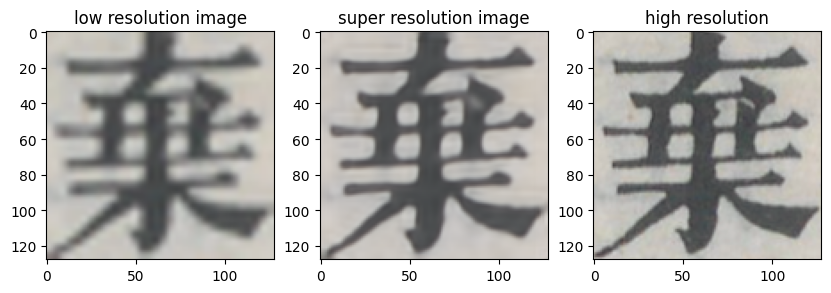

{'ssim': 0.9290655851364136, 'psnr': 30.8002872467041}


In [ ]:
lr_path = '/content/drive/MyDrive/Data/6TResize/BicubicDataset/test/low/1048.png'
hr_path = '/content/drive/MyDrive/Data/6TResize/BicubicDataset/test/high/1048.png'
state_dict_model = '/content/drive/MyDrive/Trainagain/SRCNN_200epoch/netCNN_epoch_4_200.pth'
CNN_model = SRCNN().eval()
ssim = SSIM(size_average=False)
psnr = PSNR()
lr_img = Image.open(lr_path)
hr_img = Image.open(hr_path)
upscale = UpScaleImageSRCNN(CNN_model,state_dict_model, ssim, psnr, device, lr_img, hr_img)
cnn_img = upscale.get_cnn_img()
cnn_img.save('/content/drive/MyDrive/Image/1048_cnn_200epoch.png')

metrics = upscale.metrics_calculation()

import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.title('low resolution image') # ảnh này đã được upscale bằng bicubic
plt.imshow(lr_img)

plt.subplot(1,3,2)
plt.title('super resolution image')
plt.imshow(cnn_img)


plt.subplot(1,3,3)
plt.title('high resolution')
plt.imshow(hr_img)
plt.show()
print(metrics)